Import necessary libraries
--

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import os
import glob

import SimpleITK as sitk

from PIL import Image

from scipy.misc import imread

# TensorFlow Deep learning framework
# import tensorflow as tf
# Keras framework and other packages to use tensorflow
# import keras
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

In [15]:
# Let us import annotations
annotations = pd.read_csv('CSVFILES/annotations.csv')
candidates = pd.read_csv('CSVFILES/candidates.csv')

In [20]:
annotations.tail()

,seriesuid,coordX,coordY,coordZ,diameter_mm
1181,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-160.856298,-28.560349,-269.168728,5.053694
1182,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-102.189570,-73.865766,-220.536241,4.556101
1183,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-37.535409,64.041949,-127.687101,4.357368
1184,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,43.196112,74.438486,-200.523314,4.277203
1185,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,-21.958478,33.486096,-155.292026,23.802913


In [17]:
candidates['class'].sum()

1351

In [18]:
len(annotations)

1186

In [19]:
print(len(candidates[candidates['class'] == 1]))
print(len(candidates[candidates['class'] == 0]))

1351
549714


In [7]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(num_cores)

40


Classes are heaviliy unbalanced, hardly 0.2% percent are positive.
--
The best way to move forward will be to undersample the negative class and then augment the positive class heaviliy to balance out the samples.

** Plan of attack: **

1. Get an initial subsample of negative class and keep all of the positives such that we have a 80/20 class distribution
2. Create a training set such that we augment minority class heavilby rotating to get a 50/50 class distribution

In [21]:
class CTScan(object):
    def __init__(self, filename = None, coords = None):
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None

    def reset_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        # path = glob.glob('../data/raw/*/'+ self.filename + '.mhd')
        path = glob.glob('/home/data/luna16/*/'+ self.filename + '.mhd')
        self.ds = sitk.ReadImage(path[0])
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)
    
    def get_image(self):
        return self.image
    
    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[z, y-width/2:y+width/2, x-width/2:x+width/2]
        return subImage   
    
    def normalizePlanes(self, npzarray):
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def save_image(self, filename, width):
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)

In [47]:
path = glob.glob('/home/data/luna16/*/*.mhd')
len(path)

888

In [22]:
positives = candidates[candidates['class']==1].index  
negatives = candidates[candidates['class']==0].index

In [24]:
len(positives), len(negatives)

(1351, 549714)

Check if my class works
--

In [25]:
scan = CTScan(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

In [34]:
image.shape # one scan, 194 images

(194, 512, 512)

Try it on a test set you know works
--

In [11]:
filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'
coords = (70.19, -140.93, 877.68)#[877.68, -140.93, 70.19]
scan = CTScan(filename, coords)
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

In [35]:
image.shape

(194, 512, 512)

Ok the class to get image data works
--

Next thing to do is to undersample negative class drastically. Since the number of positives in the data set of 551065 are 1351 and rest are negatives, I plan to make the dataset less skewed. Like a 70%/30% split.

In [36]:
len(positives), len(negatives)

(1351, 549714)

In [37]:
np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)

In [39]:
len(negIndexes)

6755

In [40]:
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]

In [41]:
candidatesDf

,seriesuid,coordX,coordY,coordZ,class
13,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,104.164804,-211.685591,-227.011364,1
78,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.940000,-175.040000,-297.870000,1
1303,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,70.190000,-140.930000,877.680000,1
3050,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,89.320000,190.840000,-516.820000,1
3052,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,94.930000,153.030000,-429.910000,1
3080,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,8.800000,174.740000,-401.870000,1
3223,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,88.872494,197.683673,-514.393956,1
3285,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.019566,172.593068,-405.052893,1
3287,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-23.271058,193.194724,-391.335233,1
3289,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,89.320000,143.230000,-427.100000,1


In [45]:
135100.0/(6755+1351)

16.666666666666668

In [49]:
X

NameError: name 'X' is not defined

Now split it into test train set
--

In [50]:
from sklearn.model_selection import train_test_split
X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [53]:
len(X), len(y), len(X_train), len(y_train)

(8106, 8106, 6484, 6484)

Create a validation dataset
--

In [54]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

In [55]:
len(X_train)

5187

In [18]:
X_train.to_pickle('traindata')
X_test.to_pickle('testdata')
X_val.to_pickle('valdata')

In [19]:
def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

Focus on training data
--

In [20]:
print('number of positive cases are ' + str(y_train.sum()))
print('total set size is ' + str(len(y_train)))
print('percentage of positive cases are ' + str(y_train.sum()*1.0/len(y_train)))

number of positive cases are 845
total set size is 5187
percentage of positive cases are 0.16290726817


There are 845 positive cases out of 5187 cases in the training set. We will need to augment the positive dataset like mad.
--
Add new keys to X_train and y_train for augmented data
--

In [56]:
tempDf = X_train[y_train == 1]

In [62]:
print(len(tempDf))
tempDf

845


,seriesuid,coordX,coordY,coordZ
147683,1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133...,-50.320000,88.020000,-677.090000
468235,1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853...,59.055160,-25.035106,-196.733664
66326,1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852...,85.220000,-206.430000,167.190000
222488,1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224...,99.314664,66.009823,-90.526870
30517,1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261...,-116.347267,228.041741,-565.605809
517334,1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427...,-27.130000,83.110000,-185.210000
255536,1.3.6.1.4.1.14519.5.2.1.6279.6001.239358021703...,-49.757448,83.539304,-182.120546
350845,1.3.6.1.4.1.14519.5.2.1.6279.6001.300136985030...,110.560000,3.390000,-224.480000
205637,1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948...,46.166591,170.745648,-528.435433
532504,1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545...,16.374215,-29.791809,-142.756677


In [63]:
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)

In [65]:
print(len(tempDf))
tempDf

845


,seriesuid,coordX,coordY,coordZ
1147683,1.3.6.1.4.1.14519.5.2.1.6279.6001.179162671133...,-50.320000,88.020000,-677.090000
1468235,1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853...,59.055160,-25.035106,-196.733664
1066326,1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852...,85.220000,-206.430000,167.190000
1222488,1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224...,99.314664,66.009823,-90.526870
1030517,1.3.6.1.4.1.14519.5.2.1.6279.6001.117040183261...,-116.347267,228.041741,-565.605809
1517334,1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427...,-27.130000,83.110000,-185.210000
1255536,1.3.6.1.4.1.14519.5.2.1.6279.6001.239358021703...,-49.757448,83.539304,-182.120546
1350845,1.3.6.1.4.1.14519.5.2.1.6279.6001.300136985030...,110.560000,3.390000,-224.480000
1205637,1.3.6.1.4.1.14519.5.2.1.6279.6001.211956804948...,46.166591,170.745648,-528.435433
1532504,1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545...,16.374215,-29.791809,-142.756677


In [67]:
len(X_train)

5187

In [ ]:
X_train_new = X_train.append(tempDf)

In [21]:
tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)
X_train_new = X_train_new.append(tempDf)

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000)
ytemp.loc[:] = 1

y_train_new = y_train.append(ytemp)
ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)

ytemp.loc[:] = 1
y_train_new = y_train_new.append(ytemp)

print(len(X_train_new), len(y_train_new))

6877 6877


Preprocessing
--

In [22]:
from scipy.misc import imresize
from PIL import ImageEnhance

class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image
    
    def subtract_mean(self):
        self.image = (self.image/255.0 - 0.25)*255
        return self.image
    
    def downsample_data(self):
        self.image = imresize(self.image, size = (40, 40), interp='bilinear', mode='L')
        return self.image
    
    def enhance_contrast(self):
        self.image = ImageEnhance.Contrast(self.image)
        return self.image

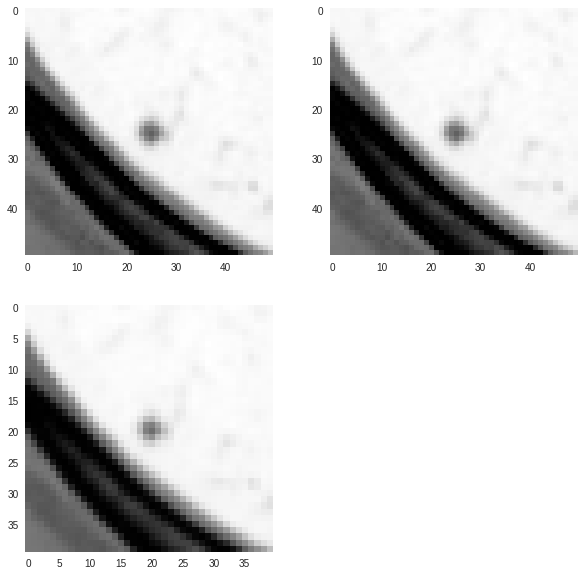

In [23]:
dirName = 'src/data/train/'
plt.figure(figsize = (10,10))
inp = imread(dirName + 'image_'+ str(30517) + '.jpg')
plt.subplot(221)
plt.imshow(inp)
plt.grid(False)

Pp = PreProcessing(inp)

inp2 = Pp.subtract_mean()
plt.subplot(222)
plt.imshow(inp2)
plt.grid(False)

#inp4 = Pp.enhance_contrast()
#plt.subplot(224)
#plt.imshow(inp4)
#plt.grid(False)

inp3 = Pp.downsample_data()
plt.subplot(223)
plt.imshow(inp3)
plt.grid(False)

#inp4 = Pp.enhance_contrast()
#plt.subplot(224)
#plt.imshow(inp4)
#plt.grid(False)

Convnet stuff
--
I am planning t us tflearn which is a wrapper around tensorflow

In [1]:
import tflearn

loading image data on the fly is inefficient. So I am us
--

In [ ]:
y_train_new.values.astype(int)

In [ ]:
train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    'src/data/train/image_'+str(x)+'.jpg')
train_filenames.values.astype(str)

In [ ]:
dataset_file = 'traindatalabels.txt'

train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    'src/data/train/image_'+str(x)+'.jpg')
   
filenames = train_filenames.values.astype(str)
labels = y_train_new.values.astype(int)
traindata = np.zeros(filenames.size,\
                     dtype=[('var1', 'S36'), ('var2', int)])
traindata['var1'] = filenames
traindata['var2'] = labels

np.savetxt(dataset_file, traindata, fmt="%10s %d")

In [ ]:
dataset_file = 'traindatalabels.txt'

# Build a HDF5 dataset (only required once)
from tflearn.data_utils import build_hdf5_image_dataset
build_hdf5_image_dataset(dataset_file, image_shape=(50, 50), mode='file', output_path='traindataset.h5', categorical_labels=True, normalize=True)